# 0. Iniciando programa

In [1]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.x13 import x13_arima_analysis
from tabulate import tabulate
import matplotlib.pyplot as plt
%matplotlib inline

diretorio = os.path.dirname(os.getcwd())
local_arquivo = os.path.join(diretorio,
                             'dados',
                             'Dados.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo)

In [2]:
# Índice trimestral do dataframe
dataframe.index = pd.date_range('1996-03', 
                               periods = len(dataframe.iloc[:, 1]),
                               freq = 'Q')
# Renomeando colunas:
dataframe.columns = 'Data', 'GDP', 'Consumption', 'average EMBI', 'EOP EMBI', 'Exports', 'Imports'

# Log das variáveis:
dataframe['GDP'] = np.log(dataframe['GDP'])
dataframe['Consumption'] = np.log(dataframe['Consumption'])
dataframe['Exports'] = np.log(dataframe['Exports'])
dataframe['Imports'] = np.log(dataframe['Imports'])
#dataframe = dataframe['1999-09':'2019']

In [144]:

local_x13_seassonal_file = os.path.join(diretorio,
                                        'notebook',
                                        'x13',
                                        'x13as')

results_gdp = x13_arima_analysis(dataframe['GDP'],x12path=local_x13_seassonal_file)
results_consumption = x13_arima_analysis(dataframe['Consumption'],x12path=local_x13_seassonal_file)
dataframe['GDP sa'] = results_gdp.seasadj
dataframe['Consumption sa'] = results_consumption.seasadj

In [145]:
dataframe.to_excel("Meus_dados.xlsx")

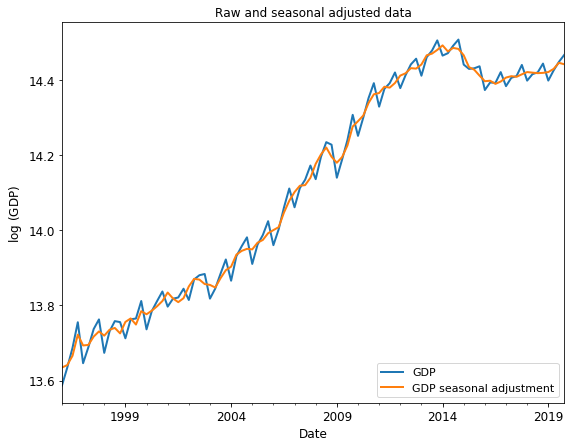

In [146]:
# Output
ax = dataframe[['GDP', 'GDP sa']].plot(title='Raw and seasonal adjusted data', fontsize=12, figsize=(9,7), lw=2)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('$\log$ (GDP)', fontsize=12)
ax.legend(['GDP', 'GDP seasonal adjustment'],loc='lower right', fontsize=11)
plt.show()

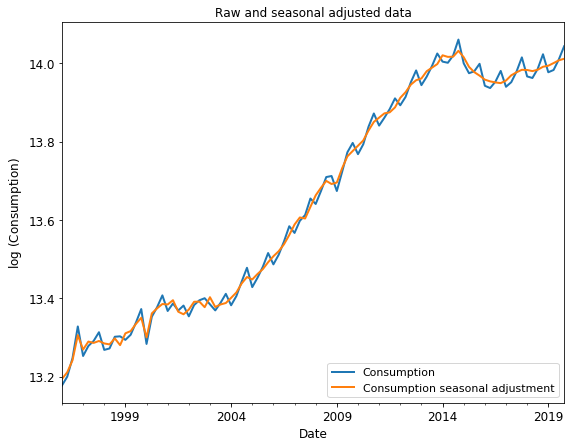

In [147]:
# Consumption
ax = dataframe[['Consumption', 'Consumption sa']].plot(title='Raw and seasonal adjusted data', fontsize=12, figsize=(9,7), lw=2)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('$\log$ (Consumption)', fontsize=12)
ax.legend(['Consumption', 'Consumption seasonal adjustment'],loc='lower right', fontsize=11)
plt.show()

In [148]:
from scipy.signal import detrend
dataframe['GDP detrended'] = detrend(dataframe['GDP sa'])
dataframe['Consumo detrended'] = detrend(dataframe['Consumption sa'])

In [149]:
import statsmodels.api as sm

x = dataframe['GDP detrended'].values[0:-1]
y = dataframe['GDP detrended'].values[1:]
model = sm.OLS(x, y)
results = model.fit()

## Parametro de Percistência

In [150]:
persistence_in_output = results.params[0]

## Parametro de Choque

In [151]:
st_dev_of_output_shock = results.bse[0]

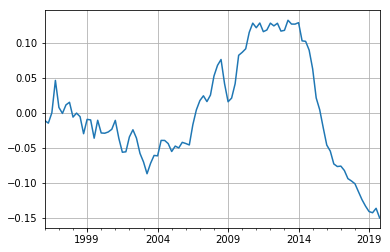

In [152]:
ax = dataframe['GDP detrended'].plot()
ax.grid(True)

In [153]:
import statsmodels.api as sm

x = dataframe['GDP detrended'].values[0:-1]
y = dataframe['GDP detrended'].values[1:]
model = sm.OLS(y, x) #<= Aqui é invertido mesmo?
results = model.fit()

In [154]:
results.params[0]

0.997070080151729

In [155]:
results.bse

array([0.0225261])

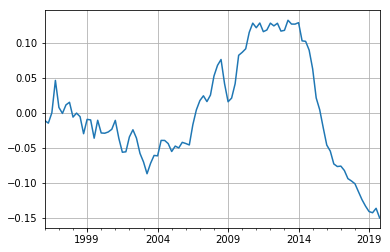

In [156]:
ax = dataframe['GDP detrended'].plot()
ax.grid(True)

In [157]:
sm.OLS?

In [158]:
y = dataframe['GDP sa']
x = np.empty([len(dataframe['GDP sa']),2])
x[:, 0], x[:, 1] = np.ones(len(x)), range(len(x))
x[:, 1] = 1 + x[:, 1]
model = sm.OLS(y, x)
results = model.fit()

In [159]:
yy = dataframe['GDP sa'] - results.params[0] - results.params[1] * x[:, 1]

In [160]:
# Tabela de Correlação

In [161]:
dataframe['Saldo BC/PIB %'] = (dataframe['Exports'] - dataframe['Imports'])/dataframe['GDP sa']

In [165]:
corre_dataframe = dataframe.drop(columns=['Data',
                        'GDP',
                        'Consumption',
                        'average EMBI',
                        'GDP sa',
                        'Consumption sa',
                        'Exports',
                        'Imports'])

,EOP EMBI,GDP detrended,Consumo detrended,Saldo BC/PIB %
EOP EMBI,1.000000,-0.293608,-0.229853,-0.106316
GDP detrended,-0.293608,1.000000,0.906366,-0.376479
Consumo detrended,-0.229853,0.906366,1.000000,-0.662771
Saldo BC/PIB %,-0.106316,-0.376479,-0.662771,1.000000


In [116]:
# A planilha de juros está na pasta dados.

local_arquivo_juros = os.path.join(diretorio,
                             'dados',
                             'Taxa de Juros Americanos Trimestre.xls')

#abrindo o arquivo em dataframe no pandas
dataframe = pd.read_excel(local_arquivo_juros)

#As datas dos arquivo ipeadata não são reconhecidos como data pelo python.
#Abaixo crio uma serie de datas trimestrais e a incluo como indice (index) do dataframe juro_americanos
dataframe.index = pd.date_range('1962-10',
                      periods=len(dataframe['DGS10 media']),
                      freq='Q')


dataframe['DGS10 media trimetral'] = [(((taxa/100)+1)**(1/4) - 1)*100 for taxa in dataframe['DGS10 media'].values]
dataframe['DGS10 fim periodo trimestral'] = [(((taxa/100)+1)**(1/4) - 1)*100 for taxa in dataframe['DGS10 fim periodo'].values]

#selecionando a coluna PIB a preços de marcado deflacionado pelo IPCA
taxa_juros_americanos_media = dataframe['DGS10 media']
taxa_juros_americanos_fim_periodo = dataframe['DGS10 fim periodo']

dataframe_juros_americanos = dataframe

In [118]:
taxa_media_juros_americano = dataframe_juros_americanos['DGS10 fim periodo trimestral'].mean()/100

# Modelo Arellano

In [182]:
import sys
sys.path.append('..')

from python.arellano_model import Arellano_Economy
    
Economia_Arellano = Arellano_Economy(β = .9599,        # time discount rate
                                     γ = 3.5,          # risk aversion
                                     r = taxa_media_juros_americano,     # international interest rate
                                     ρ = persistence_in_output,  # persistence in output
                                     η = st_dev_of_output_shock,   # st dev of output shock
                                     θ = 0.289,       # prob of regaining access
                                     ny = 21,         # number of points in y grid
                                     nB = 251,        # number of points in B grid
                                     tol = 1e-8,      # error tolerance in iteration
                                     maxit = 10000)

Running iteration 25 with dist of 0.22247924008891395
Running iteration 50 with dist of 0.06401957870404473
Running iteration 75 with dist of 0.021386031006587203
Running iteration 100 with dist of 0.007503102988426491
Running iteration 125 with dist of 0.0026753937228658486
Running iteration 150 with dist of 0.0009591150417076477
Running iteration 175 with dist of 0.0003444542594710498
Running iteration 200 with dist of 0.000123780340448576
Running iteration 225 with dist of 4.4489571585870635e-05
Running iteration 250 with dist of 1.599166180632494e-05
Running iteration 275 with dist of 5.748288813833824e-06
Running iteration 300 with dist of 2.0662685731309693e-06
Running iteration 325 with dist of 7.4273865813268e-07
Running iteration 350 with dist of 2.669842569247294e-07
Running iteration 375 with dist of 9.59699804070624e-08
Running iteration 400 with dist of 3.449731522664479e-08
Running iteration 425 with dist of 1.240038649541475e-08


## Preço Par

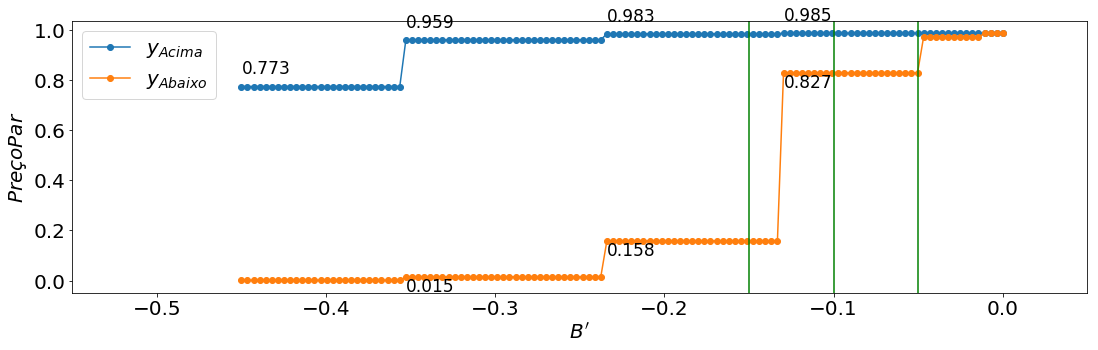

In [183]:
import importlib

import python.arellano_graficos

importlib.reload(python.arellano_graficos)


python.arellano_graficos.graficoPreco(Economia_Arellano,'PreçoPar')

## Juros

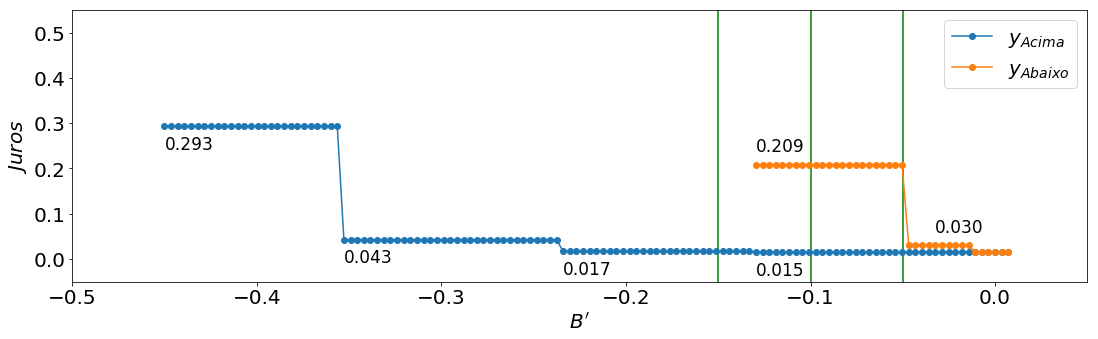

In [184]:
python.arellano_graficos.graficoJuros(Economia_Arellano,'Juros')

## Função Valor Otimo Default

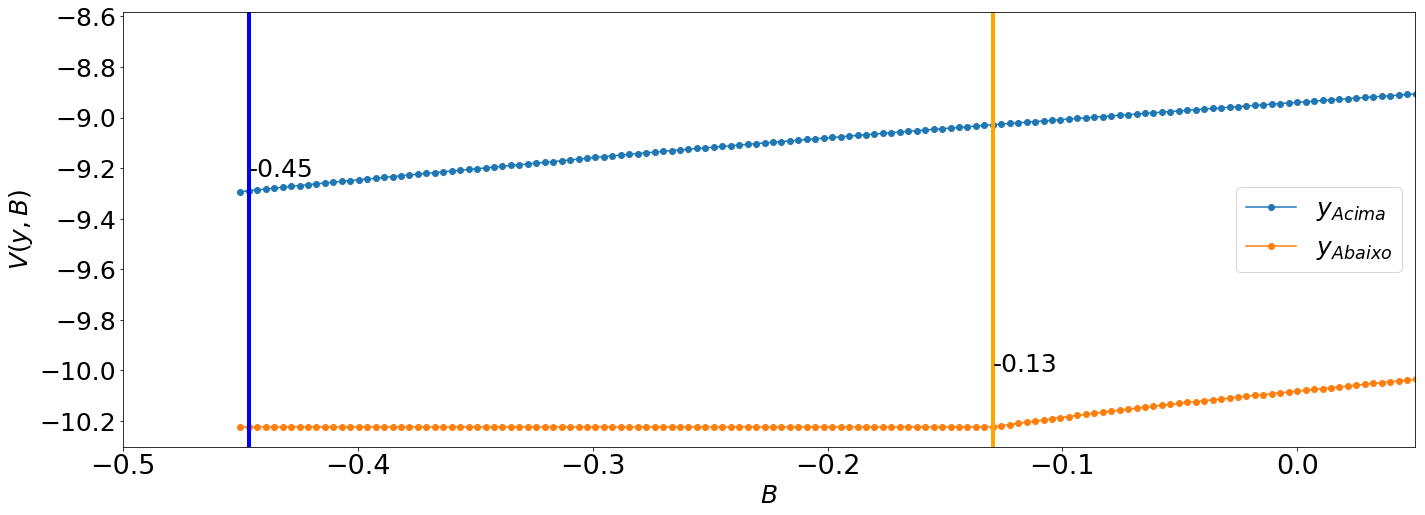

In [185]:
python.arellano_graficos.graficoFuncaoValor(Economia_Arellano,'Funcao Valor')

## Correlações Reais

In [194]:
corre_dataframe.corr(method='pearson')

,EOP EMBI,GDP detrended,Consumo detrended,Saldo BC/PIB %
EOP EMBI,1.000000,-0.293608,-0.229853,-0.106316
GDP detrended,-0.293608,1.000000,0.906366,-0.376479
Consumo detrended,-0.229853,0.906366,1.000000,-0.662771
Saldo BC/PIB %,-0.106316,-0.376479,-0.662771,1.000000


## Simulação do Ciclo

In [195]:
from python.arellano_graficos import simulacao

importlib.reload(python.arellano_graficos)

<module 'python.arellano_graficos' from '../python/arellano_graficos.py'>

In [196]:
pd.DataFrame(simulacao(Economia_Arellano)['simulacao_1'])

,dados simulados,média(x),desvio padrão(x),"corr(x,y)","corr(x,r-spread)"
0,Spread Taxa de Juros,2.88,3.40,-0.12,
1,Balança Comercial,0.49,2.01,-0.14,-0.02
2,Consumo,1.00,0.09,0.76,-0.1
3,Produto,1.01,0.07,,-0.12


In [197]:
pd.DataFrame(simulacao(Economia_Arellano)['simulacao_2'])

,variavel,valor
0,mean dívida externa,-0.05
1,mean trade balance,0.50
2,mean default Probability,0.05
